# Calculating Scattering

## Overview

**Questions**
- How do I get scattering data from a simulation?

**Objectives**
- Gain an appreciation of the Debye equation
- Understand how it would be possible to implement the Debye equation and apply it to simulation data

One of the main reasons that users of scattering techniques are interested in using molecular dynamics simulation is **compare** between the experiment and the simulation. 
However, to do this there must be some parameter that is comparable.
A commonly used method is to compare the experimental scattering profile with that generated from the simulation trajectory. 
There are many ways to derive such a profile, however we will focus only on the **Debye equation.

## The Debye equation
The Debye equation is an **analytical** formulation to determine the scattering that arises from some system. 
This equation considers the distances between particles, $r_{mn}$, to determine the scattered intensity at a given $q$-vector, $I(q)$, 

$$ I(q) = \sum_m\sum_nb_mb_n\frac{\sin{(qr_{mn})}}{qr_{mn}}, $$

where, $b_m$ and $b_n$ are the scattering lengths of atoms $m$ and $n$ respectively. 
While this is analytically-precise, there are some **problems** with this method. 
In particular, that it requires a **pair-wise summation**, which is very slow for large systems such as those used in molecular dynamics.
The Python code below is a simple implimentation of the Debye function, where the scattering length is taken as 1 for all particles.

<IPython.core.display.Javascript object>


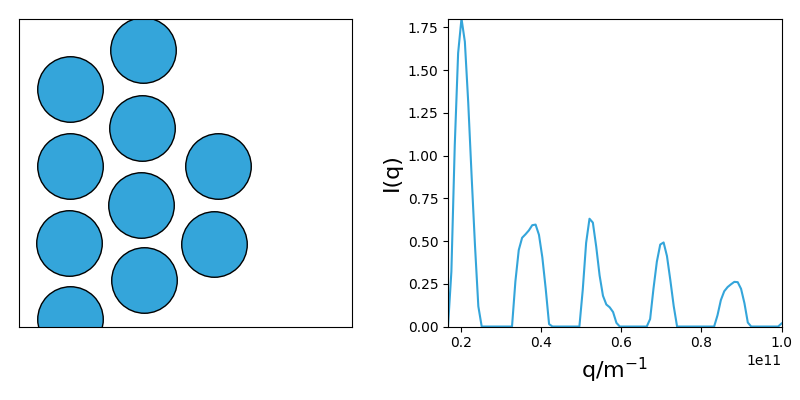

In [1]:
import numpy as np

def debye(qvalues, xposition, yposition, box_length):
    """
    Calculates the scattering profile from the simulation positions.
    
    Parameters
    ----------
    qvalues: float, array-like
        The q-vectors over which the scattering should be calculated
    xposition: float, array-like
        The positions of the particles in the x-axis
    yposition: float, array-like
        The positions of the particles in the y-axis
    box_length: float
        The length of the simulation square
        
    Returns
    -------
    intensity: float, array-like
        The calculated scattered intensity
    """
    intensity = np.zeros_like(qvalues)
    for e, q in enumerate(qvalues):
        for m in range(0, xposition.size-1):
            for n in range(m+1, xposition.size):
                xdist = xposition[n] - xposition[m]
                xdist = xdist % box_length
                ydist = yposition[n] - yposition[m]
                ydist = ydist % box_length
                r_mn = np.sqrt(np.square(xdist) + np.square(ydist))
                intensity[e] += 1 * 1 * np.sin(r_mn * q) / (r_mn * q)
        if intensity[e] < 0:
            intensity[e] = 0
    return intensity
            
from pylj import md, sample

def md_simulation(number_of_particles, temperature, box_length, number_of_steps, sample_frequency):
    """
    Runs a molecular dynamics simulation in suing the pylj molecular dynamics engine.
    
    Parameters
    ----------
    number_of_particles: int
        The number of particles in the simulation
    temperature: float
        The temperature for the initialisation and thermostating
    box_length: float
        The length of the simulation square
    number_of_steps: int
        The number of molecular dynamics steps to run
    sample_frequency: 
        How regularly the visualisation should be updated
        
    Returns
    -------
    pylj.util.System
        The complete system information from pylj
    """
    %matplotlib notebook
    system = md.initialise(number_of_particles, temperature, box_length, 'square')
    sample_system = sample.CellPlus(system, 'q/m$^{-1}$', 'I(q)')
    system.time = 0
    for i in range(0, number_of_steps):
        system.integrate(md.velocity_verlet)
        system.md_sample()
        system.heat_bath(temperature)
        system.time += system.timestep_length
        system.step += 1
        if system.step % sample_frequency == 0:
            min_q = 2. * np.pi / box_length
            qs = np.linspace(min_q, 10e10, 120)[20:]
            inten = debye(qs, system.particles['xposition'], system.particles['yposition'], box_length)
            sample_system.update(system, qs, inten)
    return system

system = md_simulation(10, 3, 15, 5000, 10)

## Exercise: Temperature effects

Try varying the temperature of the simulation, through values of 3, 30, and 300 K, and watch the scattering profile for the presence of Bragg peaks in the data when the system is cold enough to freeze.

The downfall of the Debye method is that it scales $\mathcal{O}(N^2)$, where $N$ is the number of particles, meaning that as the number of particles in the calculation increases, the time taken for the calculation **increases exponentially**. 

The inefficiency of the Debye equation has lead to a series of approximations that lead to **improved efficiency**, while keeping a high level of accuracy. 
Examples of these include the Fibonacci sequence method from Svergun, and the Golden Vectors method of Watson and Curtis [1-3].

## Exercise: Slow down
Try increasing the number of particles in the simulation (you should probably also increase the simulation cell size), and observe the change in the efficiency of the simulation. 

## Key Points
- The Debye equation is an analytical derivation for the scattering profile for a given set of atomic coordinates
- There are accurate approximations that can be utilised to save time in the calculation of the scattering.

## References

1. D. I. Svergun, (1994). *Acta Cryst.*, A50, 391-402, [10.1107/S0108767393013492](https://doi.org/10.1107/S0108767393013492)
2. M. C. Watson and J. E. Curtis, (2013). *J. Appl. Crystallogr.*, 46(4), 1171-1177, [10.1107/S002188981301666X](https://doi.org/10.1107/S002188981301666X)
3. These methods require the spherical symmetry present in three-dimensional space and therefore cannot be implemented within pylj.